In [1]:
import sys
sys.path.append('..')
import os
import pickle
import numpy as np
import warnings
import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
import imageio
from tqdm import tqdm
from src.experiment_tagging import get_model_path
from src.visualization import cluster_and_visualize
from src.lesion import perform_lesion_experiment, plot_all_damaged_clusters
from src.pointers import DATA_PATHS
from src.utils import suppress, all_logging_disabled

sns.set(font_scale=1.3)
sns.set_style('whitegrid')

if not os.path.isdir('../results'):
    os.mkdir('../results')

if not os.path.isdir('../results/lucid_ims'):
    os.mkdir('../results/lucid_ims')

if not os.path.isdir('../results/lucid_ims'):
    os.mkdir('../results/cluster_vis_corr')

n_clust = 12
n_shuffles = 20
n_workers = 10

Using TensorFlow backend.


In [2]:
# Factors of clusterability plotting

mlp_csv = '../results/clustering_factors_mlp.csv'
mlp_factors = pd.read_csv(mlp_csv)
mlp_factors = mlp_factors.loc[mlp_factors['Dataset']!='CIFAR-10']
clust_grad_csv = '../results/clustering_factors_clust_grad.csv'
clust_grad_factors = pd.read_csv(clust_grad_csv)
cnn_csv = '../results/clustering_factors_cnn.csv'
cnn_factors = pd.read_csv(cnn_csv)
cnn_factors = cnn_factors.loc[cnn_factors['Dataset']!='CIFAR-10']
cnn_vgg_csv = '../results/clustering_factors_cnn_vgg.csv'
cnn_vgg_factors = pd.read_csv(cnn_vgg_csv)
imagenet_csv = '../results/clustering_factors_imagenet.csv'
imagenet_factors = pd.read_csv(imagenet_csv)

sz = 150
figh = 6
figw = 8
fa = 0.4
color_map = 'cubehelix'

def label_points(x, y, val, ax, offset=0.03):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        if isinstance(point['val'], str):
            ax.text(point['x']+offset, point['y'], point['val'], size='small')
        elif not np.isnan(point['val']):
            ax.text(point['x']+offset, point['y'], str(round(point['val'], 2)), size='x-small')

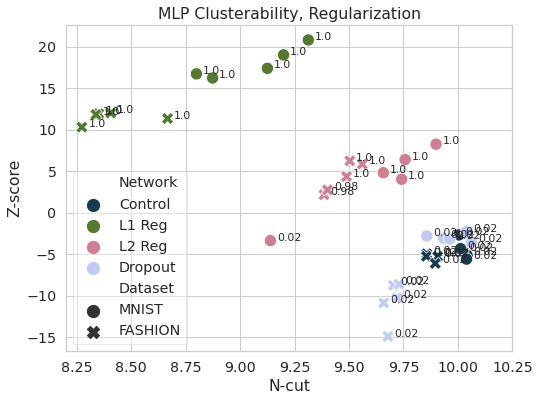

In [59]:
# MLP regularization, unpruned
factor_types = ['Control', 'L1 Reg', 'L2 Reg', 'Dropout']
dset_types = ['MNIST', 'FASHION']
subset_factors = mlp_factors.loc[mlp_factors['Dataset'].isin(dset_types)].loc[mlp_factors['Network'].isin(factor_types)]
factors_data = subset_factors

f, ax = plt.subplots(1, figsize=(figw, figh))
g = sns.scatterplot(x='ncut',
                    y='z_score',
                    style='Dataset',
                    hue='Network',
                    hue_order=factor_types,
                    style_order=dset_types,
                    s=sz,
                    palette=sns.color_palette(color_map, len(factor_types)),
                    data=factors_data,
                    ax=ax)
g.legend(framealpha=fa)
for lh in g.legend_.legendHandles:
    lh._sizes = [sz]
plt.xlim([8.2, 10.25])
plt.xlabel('N-cut')
plt.ylabel('Z-score')
plt.title(f'MLP Clusterability, Regularization')
label_points(factors_data['ncut'], factors_data['z_score'],
             factors_data['percentile'], ax)
savepath = '../results/clusterability_factors_mlp_regularization_unpruned.png'
plt.savefig(savepath, dpi=300)

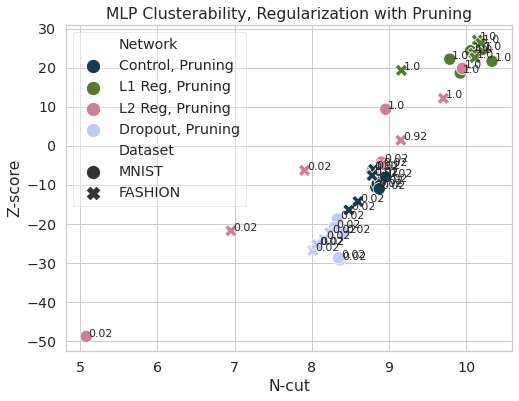

In [60]:
# MLP regularization, pruned
factor_types = ['Control, Pruning', 'L1 Reg, Pruning', 'L2 Reg, Pruning', 'Dropout, Pruning']
dset_types = ['MNIST', 'FASHION']
subset_factors = mlp_factors.loc[mlp_factors['Dataset'].isin(dset_types)].loc[mlp_factors['Network'].isin(factor_types)]
factors_data = subset_factors

f, ax = plt.subplots(1, figsize=(figw, figh))
g = sns.scatterplot(x='ncut',
                    y='z_score',
                    style='Dataset',
                    hue='Network',
                    hue_order=factor_types,
                    style_order=dset_types,
                    s=sz,
                    palette=sns.color_palette(color_map, len(factor_types)),
                    data=factors_data,
                    ax=ax)
g.legend(framealpha=fa)
for lh in g.legend_.legendHandles:
    lh._sizes = [sz]
plt.xlabel('N-cut')
plt.ylabel('Z-score')
plt.title(f'MLP Clusterability, Regularization with Pruning')
label_points(factors_data['ncut'], factors_data['z_score'],
             factors_data['percentile'], ax)
savepath = '../results/clusterability_factors_mlp_regularization_pruned.png'
plt.savefig(savepath, dpi=300)

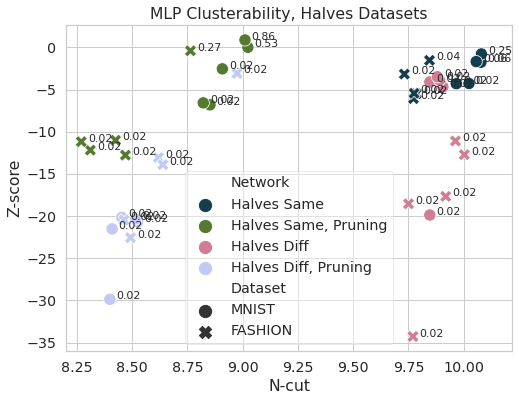

In [61]:
# MLP halves
factor_types = ['Halves Same', 'Halves Same, Pruning', 'Halves Diff', 'Halves Diff, Pruning']
dset_types = ['MNIST', 'FASHION']
subset_factors = mlp_factors.loc[mlp_factors['Dataset'].isin(dset_types)].loc[mlp_factors['Network'].isin(factor_types)]
factors_data = subset_factors

f, ax = plt.subplots(1, figsize=(figw, figh))
g = sns.scatterplot(x='ncut',
                    y='z_score',
                    style='Dataset',
                    hue='Network',
                    hue_order=factor_types,
                    style_order=dset_types,
                    s=sz,
                    palette=sns.color_palette(color_map, len(factor_types)),
                    data=factors_data,
                    ax=ax)
g.legend(framealpha=fa)
for lh in g.legend_.legendHandles:
    lh._sizes = [sz]
plt.xlim([8.2, 10.22])
plt.xlabel('N-cut')
plt.ylabel('Z-score')
plt.title(f'MLP Clusterability, Halves Datasets')
label_points(factors_data['ncut'], factors_data['z_score'],
             factors_data['percentile'], ax)
savepath = '../results/clusterability_factors_mlp_halves.png'
plt.savefig(savepath, dpi=300)

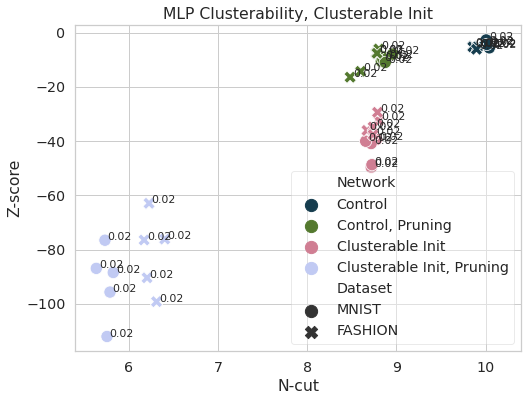

In [62]:
# MLP clusterable init
factor_types = ['Control', 'Control, Pruning', 'Clusterable Init', 'Clusterable Init, Pruning']
dset_types = ['MNIST', 'FASHION']
subset_factors = mlp_factors.loc[mlp_factors['Dataset'].isin(dset_types)].loc[mlp_factors['Network'].isin(factor_types)]
factors_data = subset_factors

f, ax = plt.subplots(1, figsize=(figw, figh))
g = sns.scatterplot(x='ncut',
                    y='z_score',
                    style='Dataset',
                    hue='Network',
                    hue_order=factor_types,
                    style_order=dset_types,
                    s=sz,
                    palette=sns.color_palette(color_map, len(factor_types)),
                    data=factors_data,
                    ax=ax)
g.legend(framealpha=fa)
for lh in g.legend_.legendHandles:
    lh._sizes = [sz]
plt.xlim(5.4, 10.4)
plt.xlabel('N-cut')
plt.ylabel('Z-score')
plt.title(f'MLP Clusterability, Clusterable Init')
label_points(factors_data['ncut'], factors_data['z_score'],
             factors_data['percentile'], ax)
savepath = '../results/clusterability_factors_mlp_clusterable_init.png'
plt.savefig(savepath, dpi=300)

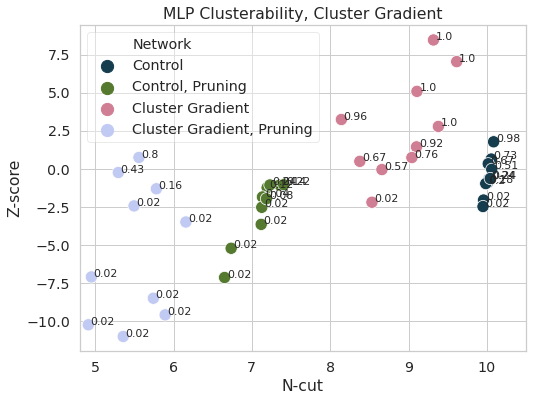

In [11]:
# MLP clust grad
factor_types = ['Control', 'Control, Pruning', 'Cluster Gradient', 'Cluster Gradient, Pruning']
subset_factors = clust_grad_factors.loc[clust_grad_factors['Network'].isin(factor_types)]
factors_data = subset_factors

f, ax = plt.subplots(1, figsize=(figw, figh))
g = sns.scatterplot(x='ncut',
                    y='z_score',
                    hue='Network',
                    hue_order=factor_types,
                    s=sz,
                    palette=sns.color_palette(color_map, len(factor_types)),
                    data=factors_data,
                    ax=ax)
g.legend(framealpha=fa)
for lh in g.legend_.legendHandles:
    lh._sizes = [sz]
plt.xlim(4.8, 10.5)
plt.xlabel('N-cut')
plt.ylabel('Z-score')
plt.title(f'MLP Clusterability, Cluster Gradient')
label_points(factors_data['ncut'], factors_data['z_score'],
             factors_data['percentile'], ax)
savepath = '../results/clusterability_factors_clust_grad.png'
plt.savefig(savepath, dpi=300)

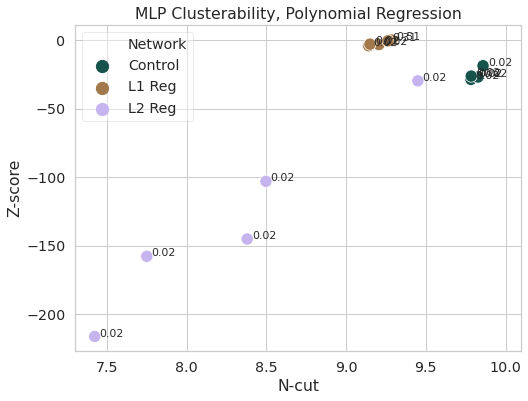

In [25]:
# MLP Polynomials
factor_types = ['Control', 'L1 Reg', 'L2 Reg']
dset_types = ['Polynomials']
subset_factors = mlp_factors.loc[mlp_factors['Dataset'].isin(dset_types)].loc[mlp_factors['Network'].isin(factor_types)]
factors_data = subset_factors

f, ax = plt.subplots(1, figsize=(figw, figh))
g = sns.scatterplot(x='ncut',
                    y='z_score',
                    hue='Network',
                    hue_order=factor_types,
                    s=sz,
                    palette=sns.color_palette(color_map, len(factor_types)),
                    data=factors_data,
                    ax=ax)
g.legend(framealpha=fa)
for lh in g.legend_.legendHandles:
    lh._sizes = [sz]
plt.xlim(7.3, 10.1)
plt.xlabel('N-cut')
plt.ylabel('Z-score')
plt.title(f'MLP Clusterability, Polynomial Regression')
label_points(factors_data['ncut'], factors_data['z_score'],
             factors_data['percentile'], ax)
savepath = '../results/clusterability_factors_mlp_poly.png'
plt.savefig(savepath, dpi=300)

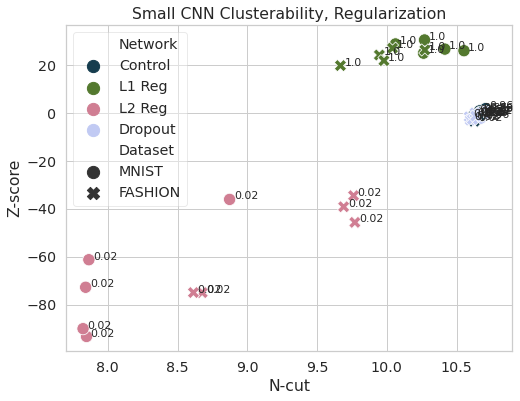

In [65]:
# CNN regularization, unpruned
factor_types = ['Control', 'L1 Reg', 'L2 Reg', 'Dropout']
dset_types = ['MNIST', 'FASHION']
subset_factors = cnn_factors.loc[cnn_factors['Dataset'].isin(dset_types)].loc[cnn_factors['Network'].isin(factor_types)]
factors_data = subset_factors

f, ax = plt.subplots(1, figsize=(figw, figh))
g = sns.scatterplot(x='ncut',
                    y='z_score',
                    style='Dataset',
                    hue='Network',
                    hue_order=factor_types,
                    style_order=dset_types,
                    s=sz,
                    palette=sns.color_palette(color_map, len(factor_types)),
                    data=factors_data,
                    ax=ax)
g.legend(framealpha=fa)
for lh in g.legend_.legendHandles:
    lh._sizes = [sz]
plt.xlim(7.7, 10.9)
plt.xlabel('N-cut')
plt.ylabel('Z-score')
plt.title(f'Small CNN Clusterability, Regularization')
label_points(factors_data['ncut'], factors_data['z_score'],
             factors_data['percentile'], ax)
savepath = '../results/clusterability_factors_cnn_regularization_unpruned.png'
plt.savefig(savepath, dpi=300)

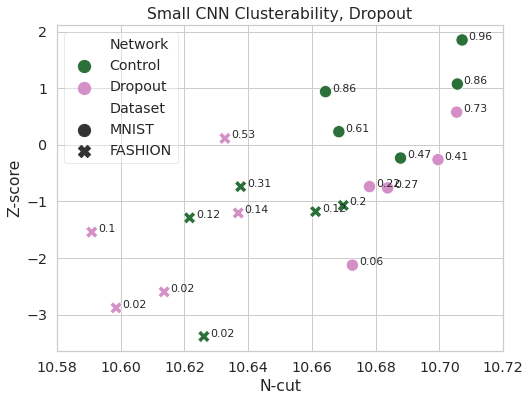

In [17]:
# CNN dropout, unpruned
factor_types = ['Control', 'Dropout']
dset_types = ['MNIST', 'FASHION']
subset_factors = cnn_factors.loc[cnn_factors['Dataset'].isin(dset_types)].loc[cnn_factors['Network'].isin(factor_types)]
factors_data = subset_factors

f, ax = plt.subplots(1, figsize=(figw, figh))
g = sns.scatterplot(x='ncut',
                    y='z_score',
                    style='Dataset',
                    hue='Network',
                    hue_order=factor_types,
                    style_order=dset_types,
                    s=sz,
                    palette=sns.color_palette(color_map, len(factor_types)),
                    data=factors_data,
                    ax=ax)
g.legend(framealpha=fa)
for lh in g.legend_.legendHandles:
    lh._sizes = [sz]
plt.xlim(10.58, 10.72)
plt.xlabel('N-cut')
plt.ylabel('Z-score')
plt.title(f'Small CNN Clusterability, Dropout')
label_points(factors_data['ncut'], factors_data['z_score'],
             factors_data['percentile'], ax, offset=0.002)
savepath = '../results/clusterability_factors_cnn_dropout_unpruned.png'
plt.savefig(savepath, dpi=300)

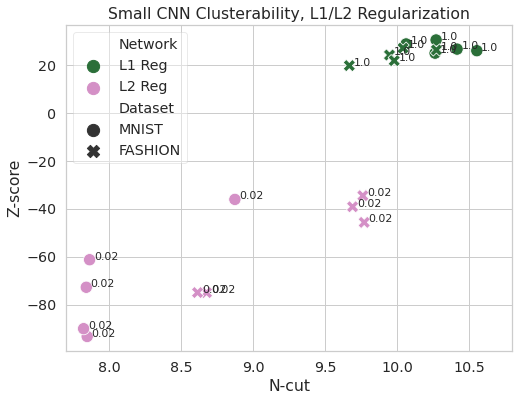

In [14]:
# CNN l1/l2 reg, unpruned
factor_types = ['L1 Reg', 'L2 Reg']
dset_types = ['MNIST', 'FASHION']
subset_factors = cnn_factors.loc[cnn_factors['Dataset'].isin(dset_types)].loc[cnn_factors['Network'].isin(factor_types)]
factors_data = subset_factors

f, ax = plt.subplots(1, figsize=(figw, figh))
g = sns.scatterplot(x='ncut',
                    y='z_score',
                    style='Dataset',
                    hue='Network',
                    hue_order=factor_types,
                    style_order=dset_types,
                    s=sz,
                    palette=sns.color_palette(color_map, len(factor_types)),
                    data=factors_data,
                    ax=ax)
g.legend(framealpha=fa)
for lh in g.legend_.legendHandles:
    lh._sizes = [sz]
plt.xlim(7.7, 10.8)
plt.xlabel('N-cut')
plt.ylabel('Z-score')
plt.title(f'Small CNN Clusterability, L1/L2 Regularization')
label_points(factors_data['ncut'], factors_data['z_score'],
             factors_data['percentile'], ax)
savepath = '../results/clusterability_factors_cnn_L1L2_unpruned.png'
plt.savefig(savepath, dpi=300)

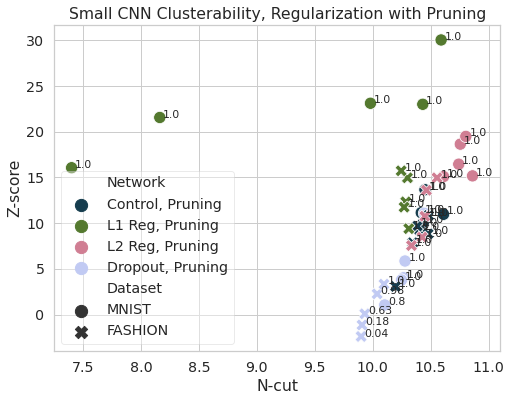

In [66]:
# CNN regularization, pruned
factor_types = ['Control, Pruning', 'L1 Reg, Pruning', 'L2 Reg, Pruning', 'Dropout, Pruning']
dset_types = ['MNIST', 'FASHION']
subset_factors = cnn_factors.loc[cnn_factors['Dataset'].isin(dset_types)].loc[cnn_factors['Network'].isin(factor_types)]
factors_data = subset_factors

f, ax = plt.subplots(1, figsize=(figw, figh))
g = sns.scatterplot(x='ncut',
                    y='z_score',
                    style='Dataset',
                    hue='Network',
                    hue_order=factor_types,
                    style_order=dset_types,
                    s=sz,
                    palette=sns.color_palette(color_map, len(factor_types)),
                    data=factors_data,
                    ax=ax)
g.legend(framealpha=fa)
for lh in g.legend_.legendHandles:
    lh._sizes = [sz]
plt.xlim(7.25, 11.1)
plt.xlabel('N-cut')
plt.ylabel('Z-score')
plt.title(f'Small CNN Clusterability, Regularization with Pruning')
label_points(factors_data['ncut'], factors_data['z_score'],
             factors_data['percentile'], ax)
savepath = '../results/clusterability_factors_cnn_regularization_pruned.png'
plt.savefig(savepath, dpi=300)

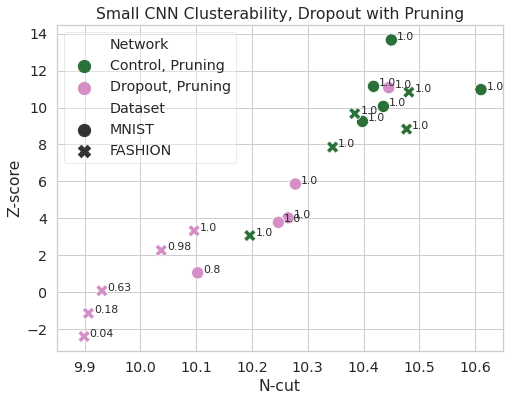

In [20]:
# CNN dropout, pruned
factor_types = ['Control, Pruning','Dropout, Pruning']
dset_types = ['MNIST', 'FASHION']
subset_factors = cnn_factors.loc[cnn_factors['Dataset'].isin(dset_types)].loc[cnn_factors['Network'].isin(factor_types)]
factors_data = subset_factors

f, ax = plt.subplots(1, figsize=(figw, figh))
g = sns.scatterplot(x='ncut',
                    y='z_score',
                    style='Dataset',
                    hue='Network',
                    hue_order=factor_types,
                    style_order=dset_types,
                    s=sz,
                    palette=sns.color_palette(color_map, len(factor_types)),
                    data=factors_data,
                    ax=ax)
g.legend(framealpha=fa)
for lh in g.legend_.legendHandles:
    lh._sizes = [sz]
plt.xlim(9.85, 10.65)
plt.xlabel('N-cut')
plt.ylabel('Z-score')
plt.title(f'Small CNN Clusterability, Dropout with Pruning')
label_points(factors_data['ncut'], factors_data['z_score'],
             factors_data['percentile'], ax, offset=0.01)
savepath = '../results/clusterability_factors_cnn_dropout_pruned.png'
plt.savefig(savepath, dpi=300)

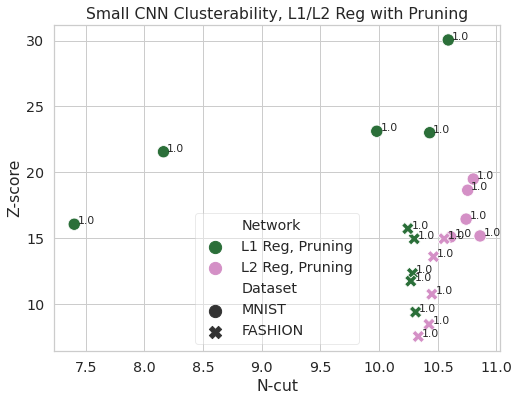

In [19]:
# CNN l1/l2 reg, pruned
factor_types = ['L1 Reg, Pruning', 'L2 Reg, Pruning']
dset_types = ['MNIST', 'FASHION']
subset_factors = cnn_factors.loc[cnn_factors['Dataset'].isin(dset_types)].loc[cnn_factors['Network'].isin(factor_types)]
factors_data = subset_factors

f, ax = plt.subplots(1, figsize=(figw, figh))
g = sns.scatterplot(x='ncut',
                    y='z_score',
                    style='Dataset',
                    hue='Network',
                    hue_order=factor_types,
                    style_order=dset_types,
                    s=sz,
                    palette=sns.color_palette(color_map, len(factor_types)),
                    data=factors_data,
                    ax=ax)
g.legend(framealpha=fa)
for lh in g.legend_.legendHandles:
    lh._sizes = [sz]
# plt.xlim(7.25, 11.1)
plt.xlabel('N-cut')
plt.ylabel('Z-score')
plt.title(f'Small CNN Clusterability, L1/L2 Reg with Pruning')
label_points(factors_data['ncut'], factors_data['z_score'],
             factors_data['percentile'], ax)
savepath = '../results/clusterability_factors_cnn_L1L2_pruned.png'
plt.savefig(savepath, dpi=300)

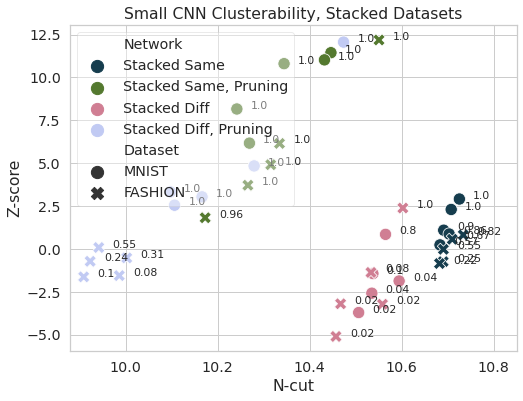

In [67]:
# CNN stacked datasets
factor_types = ['Stacked Same', 'Stacked Same, Pruning', 'Stacked Diff', 'Stacked Diff, Pruning']
dset_types = ['MNIST', 'FASHION']
subset_factors = cnn_factors.loc[cnn_factors['Dataset'].isin(dset_types)].loc[cnn_factors['Network'].isin(factor_types)]
factors_data = subset_factors

f, ax = plt.subplots(1, figsize=(figw, figh))
g = sns.scatterplot(x='ncut',
                    y='z_score',
                    style='Dataset',
                    hue='Network',
                    hue_order=factor_types,
                    style_order=dset_types,
                    s=sz,
                    palette=sns.color_palette(color_map, len(factor_types)),
                    data=factors_data,
                    ax=ax)
g.legend(loc='upper left', framealpha=fa)
for lh in g.legend_.legendHandles:
    lh._sizes = [sz]
plt.xlim(9.88, 10.85)
plt.xlabel('N-cut')
plt.ylabel('Z-score')
plt.title(f'Small CNN Clusterability, Stacked Datasets')
label_points(factors_data['ncut'], factors_data['z_score'],
             factors_data['percentile'], ax)
savepath = '../results/clusterability_factors_cnn_stacked.png'
plt.savefig(savepath, dpi=300)

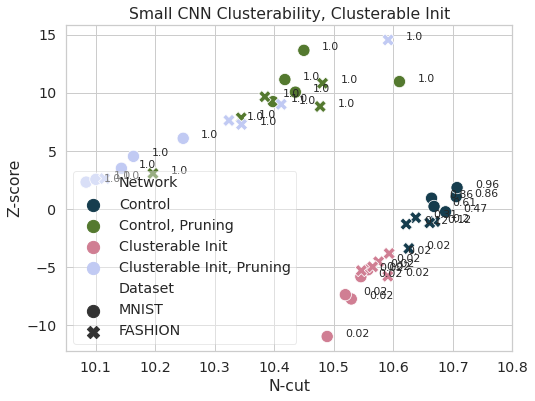

In [68]:
# CNN clusterable init
factor_types = ['Control', 'Control, Pruning', 'Clusterable Init', 'Clusterable Init, Pruning']
dset_types = ['MNIST', 'FASHION']
subset_factors = cnn_factors.loc[cnn_factors['Dataset'].isin(dset_types)].loc[cnn_factors['Network'].isin(factor_types)]
factors_data = subset_factors

f, ax = plt.subplots(1, figsize=(figw, figh))
g = sns.scatterplot(x='ncut',
                    y='z_score',
                    style='Dataset',
                    hue='Network',
                    hue_order=factor_types,
                    style_order=dset_types,
                    s=sz,
                    palette=sns.color_palette(color_map, len(factor_types)),
                    data=factors_data,
                    ax=ax)
g.legend(framealpha=fa)
for lh in g.legend_.legendHandles:
    lh._sizes = [sz]
plt.xlim(10.05, 10.8)
plt.xlabel('N-cut')
plt.ylabel('Z-score')
plt.title(f'Small CNN Clusterability, Clusterable Init')
label_points(factors_data['ncut'], factors_data['z_score'],
             factors_data['percentile'], ax)
savepath = '../results/clusterability_factors_cnn_clusterable_init.png'
plt.savefig(savepath, dpi=300)

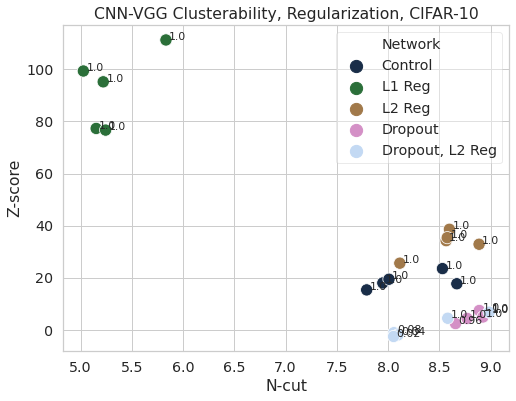

In [69]:
# VGG CNN regularization, unpruned
factor_types = ['Control', 'L1 Reg', 'L2 Reg', 'Dropout', 'Dropout, L2 Reg']
subset_factors = cnn_vgg_factors.loc[cnn_vgg_factors['Network'].isin(factor_types)]
factors_data = subset_factors

f, ax = plt.subplots(1, figsize=(figw, figh))
g = sns.scatterplot(x='ncut',
                    y='z_score',
                    hue='Network',
                    hue_order=factor_types,
                    s=sz,
                    palette=sns.color_palette(color_map, len(factor_types)),
                    data=factors_data,
                    ax=ax)
g.legend(framealpha=fa)
for lh in g.legend_.legendHandles:
    lh._sizes = [sz]
plt.xlabel('N-cut')
plt.ylabel('Z-score')
plt.title(f'CNN-VGG Clusterability, Regularization, CIFAR-10')
label_points(factors_data['ncut'], factors_data['z_score'],
             factors_data['percentile'], ax)
savepath = '../results/clusterability_factors_cnn_vgg_regularization_unpruned.png'
plt.savefig(savepath, dpi=300)

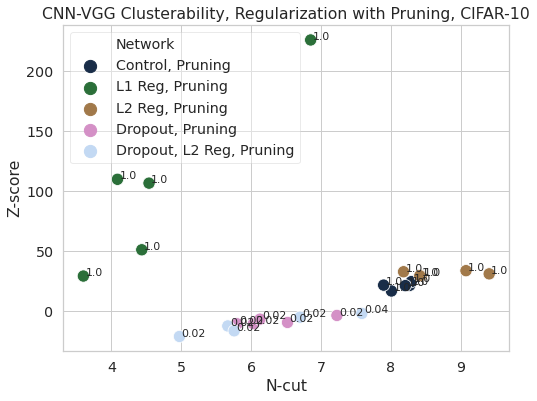

In [70]:
# VGG CNN regularization, pruned
factor_types = ['Control, Pruning', 'L1 Reg, Pruning', 'L2 Reg, Pruning', 
                'Dropout, Pruning', 'Dropout, L2 Reg, Pruning']
subset_factors = cnn_vgg_factors.loc[cnn_vgg_factors['Network'].isin(factor_types)]
factors_data = subset_factors

f, ax = plt.subplots(1, figsize=(figw, figh))
g = sns.scatterplot(x='ncut',
                    y='z_score',
                    hue='Network',
                    hue_order=factor_types,
                    s=sz,
                    palette=sns.color_palette(color_map, len(factor_types)),
                    data=factors_data,
                    ax=ax)
g.legend(framealpha=fa)
for lh in g.legend_.legendHandles:
    lh._sizes = [sz]
plt.xlabel('N-cut')
plt.ylabel('Z-score')
plt.title(f'CNN-VGG Clusterability, Regularization with Pruning, CIFAR-10')
label_points(factors_data['ncut'], factors_data['z_score'],
             factors_data['percentile'], ax)
savepath = '../results/clusterability_factors_cnn_vgg_regularization_pruned.png'
plt.savefig(savepath, dpi=300)

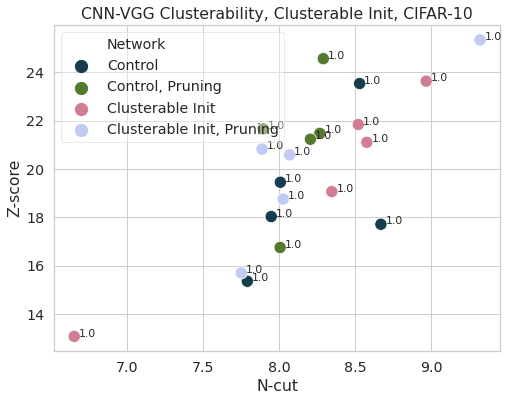

In [71]:
# VGG CNN clusterable init
factor_types = ['Control', 'Control, Pruning', 'Clusterable Init', 'Clusterable Init, Pruning']
subset_factors = cnn_vgg_factors.loc[cnn_vgg_factors['Network'].isin(factor_types)]
factors_data = subset_factors

f, ax = plt.subplots(1, figsize=(figw, figh))
g = sns.scatterplot(x='ncut',
                    y='z_score',
                    hue='Network',
                    hue_order=factor_types,
                    s=sz,
                    palette=sns.color_palette(color_map, len(factor_types)),
                    data=factors_data,
                    ax=ax)
g.legend(framealpha=fa)
for lh in g.legend_.legendHandles:
    lh._sizes = [sz]
plt.xlabel('N-cut')
plt.ylabel('Z-score')
plt.title(f'CNN-VGG Clusterability, Clusterable Init, CIFAR-10')
label_points(factors_data['ncut'], factors_data['z_score'],
             factors_data['percentile'], ax)
savepath = '../results/clusterability_factors_cnn_vgg_clusterable_init.png'
plt.savefig(savepath, dpi=300)

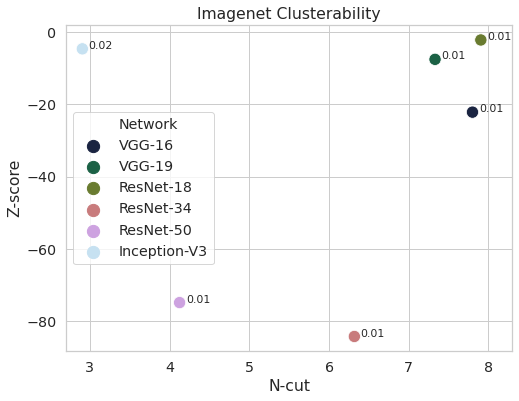

In [9]:
# Imagenet
factor_types = ['VGG-16', 'VGG-19', 'ResNet-18', 'ResNet-34', 'ResNet-50', 'Inception-V3']
factors_data = imagenet_factors

f, ax = plt.subplots(1, figsize=(figw, figh))
g = sns.scatterplot(x='ncut',
                    y='z_score',
                    hue='Network',
                    hue_order=factor_types,
                    s=sz,
                    palette=sns.color_palette(color_map, len(factor_types)),
                    data=factors_data,
                    ax=ax)
g.legend(framealpha=fa)
g.legend(loc='center left')
for lh in g.legend_.legendHandles:
    lh._sizes = [sz]
plt.xlim(2.7, 8.3)
plt.xlabel('N-cut')
plt.ylabel('Z-score')
plt.title(f'Imagenet Clusterability')
label_points(factors_data['ncut'], factors_data['z_score'],
             factors_data['percentile'], ax, offset=0.08)
savepath = '../results/clusterability_factors_imagenet.png'
plt.savefig(savepath, dpi=300)

In [4]:
# Save cluster vis corr images

vis_tags = ['MNIST+DROPOUT', 'HALVES-MNIST+DROPOUT', 'HALVES-SAME-MNIST+DROPOUT',
            'HALVES-MNIST', 'HALVES-SAME-MNIST',
            'FASHION+DROPOUT','CNN-STACKED-SAME-MNIST', 'CNN-STACKED-MNIST']
is_unpruned = False

with suppress(), all_logging_disabled():
    for tag in tqdm(vis_tags):
        model_path = get_model_path(tag)
        side_len = 32 if 'VGG' in tag else 28
        vis_results = cluster_and_visualize(model_path, model_path, side_len=side_len,
                                            n_clusters=n_clust, filter_norm=1)
        all_columns = []
        for lyr_i, lyr in enumerate(vis_results[is_unpruned]):
            for clust in vis_results[is_unpruned][lyr]:
                ims = vis_results[is_unpruned][lyr][clust]['ims']
                if ims[0].shape[0] > 1:
                    all_vis = np.concatenate([np.squeeze(im) for im in ims], axis=1)
                else:
                    all_vis = np.concatenate([np.squeeze(im) for im in ims], axis=0)
                all_vis -= np.min(all_vis)  # normalize to have values in in [0,1]
                all_vis /= np.max(all_vis)  # normalize to have values in in [0,1]
                if len(ims) > 1:
                    all_columns.append(all_vis)

        all_cols_vis = np.concatenate(all_columns, axis=-1)
        if len(all_cols_vis.shape) > 2:
            if all_cols_vis.shape[0] < 3:
                zero_red = np.expand_dims(np.zeros((all_cols_vis.shape[1], all_cols_vis.shape[2])), axis=0)
                all_cols_vis = np.concatenate([zero_red, all_cols_vis], axis=0)
            white_line = np.ones((3, 1, all_cols_vis.shape[-1]))
            all_cols_vis = np.concatenate([all_cols_vis[:, :side_len, :], white_line, 
                                           all_cols_vis[:, side_len:, :]], axis=1)
            all_cols_vis = np.transpose(all_cols_vis, axes=(1, 2, 0))  # channels last
        else:
            white_line = np.ones((1, all_cols_vis.shape[-1]))
            all_cols_vis = np.vstack([all_cols_vis[:side_len, :], white_line, all_cols_vis[side_len:, :]])
        if np.max(all_cols_vis) <= 1.0:
            all_cols_vis *= 255
        savename = '../results/cluster_vis_corr_' + tag + '_unpruned=' + str(is_unpruned) + '.png'
        savename = savename.replace('+', '_').replace('-', '_')
        imageio.imwrite(savename, all_cols_vis)

In [18]:
# Save some example lucid visualizations

data_dir='../datasets/'
image_dir = '../results/lucid_ims/'
model_tags = ('MNIST+LUCID', 'CNN-MNIST+LUCID', 'CNN-VGG-CIFAR10+DROPOUT+L2REG')
imagenet_nets = ('vgg16', 'vgg19', 'resnet50')

with suppress(), all_logging_disabled():

    for tag in model_tags:

        for is_unpruned in [True, False]:

            suff = '_unpruned_max_data.pkl' if is_unpruned else '_pruned_max_data.pkl'
            pruning_str = '_unpruned' if is_unpruned else '_pruned'

            with open(data_dir + tag + '0' + suff, 'rb') as f:
                data = pickle.load(f)

            max_images = data['max_images']
            random_max_images = data['random_max_images']
            sm_sizes = data['sm_sizes']
            sm_layers = data['sm_layers']
            sm_layer_sizes = data['sm_layer_sizes']
            n_examples = len(sm_sizes)
            n_random = int(len(random_max_images) / n_examples)

            all_random = [np.hstack(random_max_images[i*n_random: (i+1)*n_random]) for i in range(n_examples)]

            for i in range(n_examples):
                savename = image_dir + tag + pruning_str + '_layer' + str(sm_layers[i]).replace('/', '') + \
                           '_layersize' + str(sm_layer_sizes[i]) + '_size' + str(sm_sizes[i]) + '.png'
                random_savename = image_dir + tag + pruning_str + '_layer' + str(sm_layers[i]).replace('/', '') + \
                                  '_layersize' + str(sm_layer_sizes[i]) + '_size' + str(sm_sizes[i]) + '_random.png'
                savename = savename.replace('+', '_').replace('-', '_')
                random_savename = random_savename.replace('+', '_').replace('-', '_')
                imageio.imwrite(savename, max_images[i])
                imageio.imwrite(random_savename, all_random[i])

    for net in imagenet_nets:

        with open(data_dir + net + '_max_data.pkl', 'rb') as f:
            data = pickle.load(f)

        max_images = data['max_images']
        random_max_images = data['random_max_images']
        sm_sizes = data['sm_sizes']
        sm_layers = data['sm_layers']
        sm_layer_sizes = data['sm_layer_sizes']
        n_examples = len(sm_sizes)
        n_random = int(len(random_max_images) / n_examples)

        all_random = [np.hstack(random_max_images[i*n_random: (i+1)*n_random]) for i in range(n_examples)]

        for i in range(n_examples):
            savename = image_dir + net + '_layer' + str(sm_layers[i]).replace('/', '') + \
                       '_layersize' + str(sm_layer_sizes[i]) + '_size' + str(sm_sizes[i]) + '.png'
            random_savename = image_dir + net + '_layer' + str(sm_layers[i]).replace('/', '') + \
                              '_layersize' + str(sm_layer_sizes[i]) + '_size' + str(sm_sizes[i]) + '_random.png'
            savename = savename.replace('+', '_').replace('-', '_')
            random_savename = random_savename.replace('+', '_').replace('-', '_')
            if np.max(max_images[i]) <= 1.0:
                max_images[i] *= 255
                all_random[i] *= 255
            imageio.imwrite(savename, max_images[i])
            imageio.imwrite(random_savename, all_random[i])


100%|██████████| 2/2 [05:31<00:00, 165.57s/it]


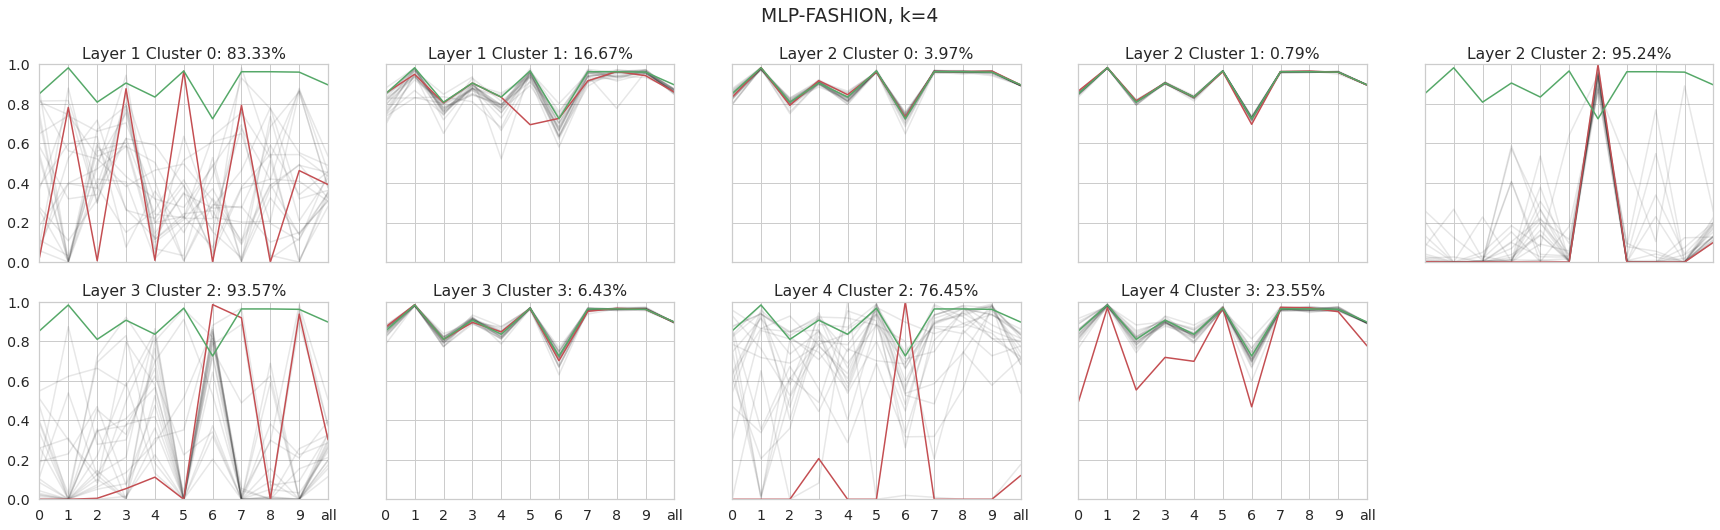

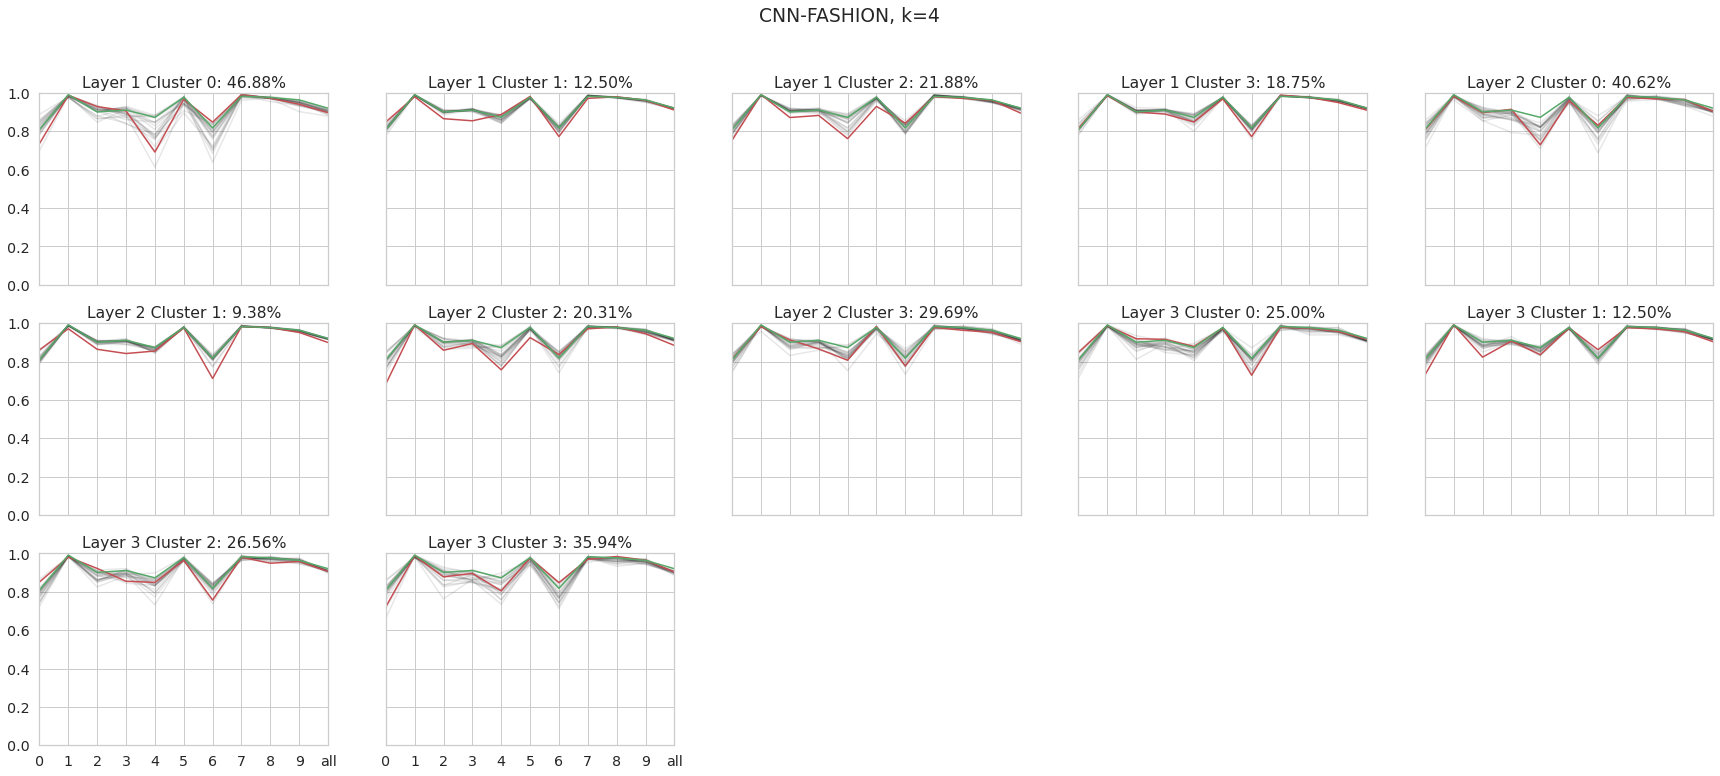

In [19]:
# Save some example lesion visualizations

n_clust = 4
# os.environ['CUDA_VISIBLE_DEVICES'] = '3'
lesion_models = (('fashion', 'FASHION'), ('fashion', 'CNN-FASHION'), 
                 #('poly', 'POLY')
                )

with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    for dataset_name, model_name in tqdm(lesion_models):

        if 'CNN' in model_name:
            is_unpruned = True
        else:
            is_unpruned = False

        (true_results,
         all_random_results,
         metadata,
         evaluation) = perform_lesion_experiment('.' + DATA_PATHS[dataset_name],
                                                 get_model_path(model_name), n_clusters=n_clust,
                                                 n_shuffles=n_shuffles, unpruned=is_unpruned)

        model_and_dataset = model_name if 'CNN' in model_name else 'MLP-' + model_name
        axes = plot_all_damaged_clusters(true_results, all_random_results,
                                         metadata, evaluation, title=f'{model_and_dataset}, k={n_clust}')
        savename = '../results/lesion_' + model_name + '_unpruned=' + str(is_unpruned) + '.png'
        plt.savefig(savename)

